In [8]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt

In [9]:
def feature_vs_n_tau_q(visualization_df, features):
    '''
    This function takes in a pandas dataframe, which contains the columns "n", "tau", and "Q" as extracted from the
    curve fit components as well as any geometric or material features the user wish to investigate. A paneled plot
    will be created to analyze the relationship(s) between a feature and any fitting parameter (n, tau, and Q).
    Input:
     - visualization_df: a dataframe that contains column names specified by *features*
     - features: columns in *visualization_df* to be plotted
    Output:
     - A panel plot with three columns (n, tau, and Q) and x rows, where x is the number of features.
    '''
    # Test that the input dataframe has the requried columns named correctly
    assert 'n' in visualization_df, 'The dataframe is missing the "n" column'
    assert 'tau' in visualization_df, 'The dataframe is missing the "tau" column'
    assert 'Q' in visualization_df, 'The dataframe is missing the "Q" column'
    matplotlib.rcParams.update({'font.size': 24})
    fig = plt.figure(figsize=(36,10*len(features)))
    ax = fig.subplots(nrows=len(features),ncols=3)
    # For analysis with more than 1 features
    if len(features) > 1:
        for i, feature in enumerate(features):
            ## LEFT COLUMN (feature vs. 'n')
            ax[i,0].scatter(visualization_df[feature].values, visualization_df['n'].values, color='blue', s = 500)
            ax[i,0].set_xlabel(feature)
            ax[i,0].set_ylabel('n')
            ## MIDDLE COLUMN (feature vs. 'tau')
            ax[i,1].scatter(visualization_df[feature], visualization_df['tau'], color='red', s = 500)
            ax[i,1].set_xlabel(feature)
            ax[i,1].set_ylabel('tau')
            ax[i,1].semilogy()
            ## RIGHT COLUMN (feature vs. 'Q')      
            ax[i,2].scatter(visualization_df[feature], visualization_df['Q'], color='green', s = 500)
            ax[i,2].set_xlabel(feature)
            ax[i,2].set_ylabel('Q')
    # For analysis with only 1 feature
    elif len(features) == 1:
        for i, feature in enumerate(features):
            ## LEFT COLUMN (feature vs. 'n')
            ax[0].scatter(visualization_df[feature].values, visualization_df['n'].values, color='blue', s = 500)
            ax[0].set_xlabel(feature)
            ax[0].set_ylabel('n')
            ## MIDDLE COLUMN (feature vs. 'tau')
            ax[1].scatter(visualization_df[feature], visualization_df['tau'], color='red', s = 500)
            ax[1].set_xlabel(feature)
            ax[1].set_ylabel('tau')
            ax[1].semilogy()
            ## RIGHT COLUMN (feature vs. 'Q')      
            ax[2].scatter(visualization_df[feature], visualization_df['Q'], color='green', s = 500)
            ax[2].set_xlabel(feature)
            ax[2].set_ylabel('Q')        
    plt.tight_layout()
    return fig

In [10]:
def test_feature_vs_n_tau_q():
    '''
    This function tests the raised error type when
    the column names for fitting parameters are wrong.
    This function also uses a test case to ensure the
    function returns the correct figure grid number.
    '''
    df1 = pd.DataFrame({'n':[1,2,3],
                        'tau':[0.1, 0.2, 0.3],
                        'Q':[100, 200, 300],
                        'cathode_thickness':[20, 30, 40]})
    df2 = pd.DataFrame({'n':[1,2,3],
                        'cathode_thickness':[20, 30, 40]})
    # Test that the function output the correct 
    # error type whem missing columns 'n', 'tau', and 'Q'
    try:
        feature_vs_n_tau_q(df2, ['cathode_thickness'])
    except Exception as e:
        assert isinstance(e, AssertionError),"feature_vs_n_tau_Q() \
                           Function outputs the wrong error type \
                           when the dataframe has wrong column names."
    # Test that the function outputs the correct number of panels
    fig = feature_vs_n_tau_q(df1, ['cathode_thickness'])
    row, col = fig.axes[0].get_subplotspec().get_topmost_subplotspec().get_gridspec().get_geometry()
    assert np.isclose(row,1) & np.isclose(col,3), 'Unexpected figure grid size'
        
    return

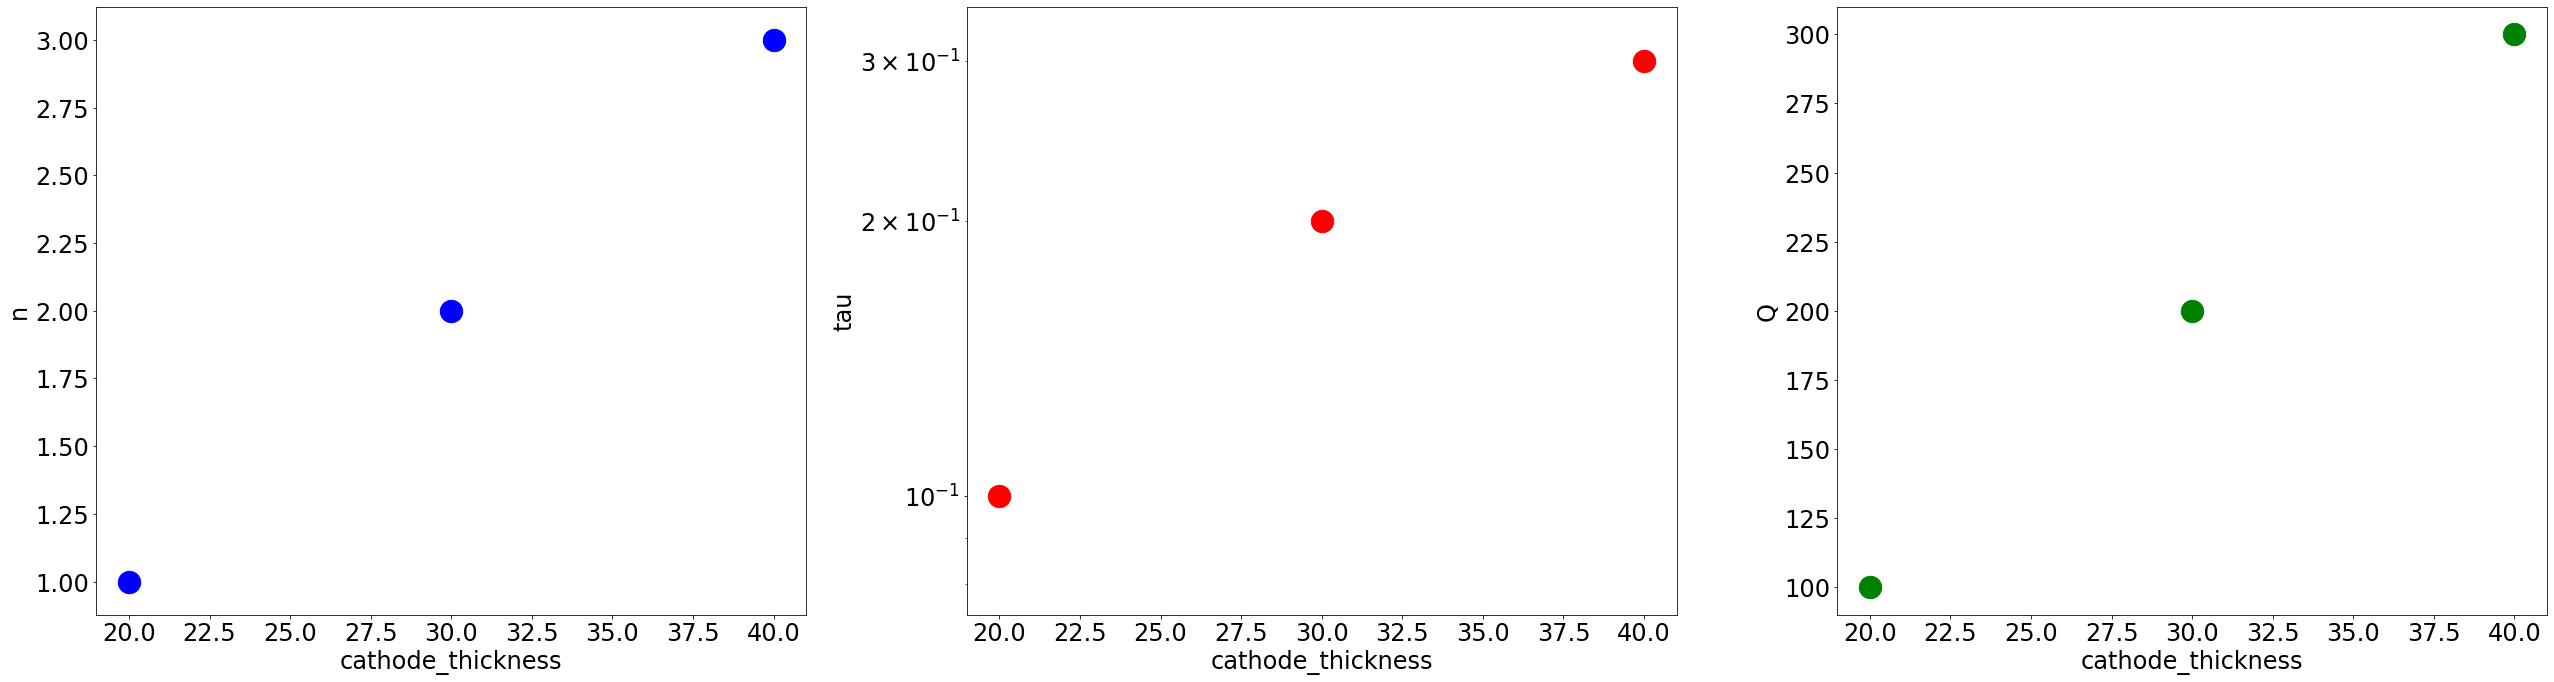

In [11]:
test_feature_vs_n_tau_q()

In [12]:
"""
This module is used to convert battery cycling data
and battery charge/discharge data into capacity-rate data.
"""
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from sklearn.mixture import GaussianMixture


def potential_rate_paper_set(input_file, sheet_name,
                             output_file, paper_num, set_num):
    """
    This function converts potential vs. capacity data to capacity vs c-rate
    data. The Highest x-value (capacity [mAh]) from the charge/discharge graph.
    The input excel file has the format that each excel file has many sheets
    and each sheet, separated by charge/discharge C-rate, contains many papers.
    Each paper can have more than 1 set of capacity versus voltage data, each
    occupying 1 column (i.e. each set takes up two columns). The first row of
    a sheet specifies the paper code number, e.g. 'paper # 1', and the second
    row of a sheet spcifies the battery's set number, e.g. 'set # 1', and the
    third row of a sheet contains the quantity name and units, e.g. 'Capacity
    (mAh/g)' and 'Voltage (V)'.
    PARAMETERS
    ----------
    1) Excel file (file path) - string
    2) sheetnames - list
    3) Paper # - string
    4) Set # - integer: max number of sets
    RETURNS
    -------
    Capacity vs c-rate dataframe
    """
    # Determining which set # and the number of set lists from the excel file
    set_list = ['set #' + str(i) for i in range(1, set_num + 1)]
    # Test that the input 'set_num' is an integer
    assert isinstance(set_num, int) is True, 'set_num must be an integer'
    # Dataframing the interested potential vs capacity excel sheet
    df_input = pd.read_excel(input_file, sheet_name, header=[0, 1, 2])
    # Merging multiple spreadsheets
    df_sheets = []
    for i in sheet_name:
        df_sheets.append(df_input[i])
    df_merged = pd.concat(df_sheets, axis=1)
    # Get C-rate numerical values
    rates = []
    for name in sheet_name:
        rate = name.split("C_")[0]
        rates.append(rate)
    c_rate = pd.DataFrame({"C rate": rates})
    # Selecting maximum capacity values for each dataset and
    # concatnate with corresponding c-rates or current density
    caplist = []
    for i in set_list:
        set_i = (df_merged[paper_num, i])
        set_i_max = set_i["Capacity (mAh/g)"].max(axis=0).array
        caplist.append(c_rate)
        caplist.append(pd.DataFrame({"Capacity (mAh/g)": set_i_max}))
    df_cap_rate = pd.concat(caplist, axis=1)
    # Test that the output is a dataframe
    assert isinstance(c_rate,
                      df_cap_rate) is True, 'The output must be a dataframe'
    # Exporting the converted dataframe to an excel file
    workbook = openpyxl.Workbook()
    worksheet = workbook.active
    for row in dataframe_to_rows(df_cap_rate, index=True, header=True):
        worksheet.append(row)
    workbook.save(output_file)
#     df_cap_rate.to_excel(output_file,sheet_name=paper_num,
#                          index=False, header=True)
    # Test that the sheet name is a string
    assert isinstance(paper_num, str) is True, 'sheetname must be a string'
    print('saved succesfully to' + output_file)
    return df_cap_rate


def potential_rate_all(input_file, output_file):
    """
    This function converts and dataframes all voltage potential data and
    separates them by paper and set numbers such that the users can see
    what options they have. The input excel file has the format that each
    excel file has many sheets and each sheet, separated by charge/discharge
    C-rate, contains many papers. Each paper can have more than 1 set of
    capacity versus voltage data, each occupying 1 column (i.e. each set
    takes up two columns). The first row of a sheet specifies the paper code
    number, e.g. 'paper # 1', and the second row of a sheet spcifies the
    battery's set number, e.g. 'set # 1', and the third row of a sheet
    contains the quantity name and units, e.g. 'Capacity (mAh/g)' and
    'Voltage (V)'.
    PARAMETERS
    ----------
    1) Excel file (file path) - string
    2) Output Excel file name - string
    RETURNS
    -------
    A voltage-capaity dataframe by paper and set number
    """
    # Read all sheets in the input file into a dictionary
    dict_excel = pd.read_excel(input_file, sheet_name=None, header=[0, 1, 2])
    sheetnames = list(dict_excel.keys())
#     dict_excel[sheetnames[0]]
    df_cap_rate = pd.DataFrame()
    for _, sheetname in enumerate(sheetnames):
        df_input = dict_excel[sheetname]
        rate = sheetname.split("C_")[0]
        for headers, columnval in df_input.items():
            paper_num, set_num, quan = headers
            # Takes only the capacity data
            if 'capacity' in quan or 'Capacity' in quan:
                max_cap = np.nanmax(columnval.values)
                # Must create the dataframe first
                # before adding multiple headers
                newdf = pd.DataFrame([[rate, max_cap]])
                # Add headers
                newdf_header = [[paper_num, paper_num],
                                [set_num, set_num], ['C-rate', quan]]
                newdf.columns = newdf_header
                df_cap_rate = pd.concat([df_cap_rate, newdf])
    # apply lambda function to each column to drop Nans
    df_cap_rate_all = df_cap_rate.apply(lambda x: pd.Series(x.dropna().values))
    # Export dataframe to Excel
    workbook = openpyxl.Workbook()
    worksheet = workbook.active
    for row in dataframe_to_rows(df_cap_rate_all, index=True, header=True):
        worksheet.append(row)
    workbook.save(output_file)
#     df_cap_rate_all.to_excel(output_file,sheet_name='CapacityRate',
#                              index=True, header=True)
    return df_cap_rate_all


def excel_merge(dataframe, xls_file, sheetname):
    """
    This function adds the converted dataframe to an existing excel file
    PARAMETERS
    ----------
    1) converted dataframe - dataframe
    2) Excel file (file path) - string
    3) sheetname - string
    RETURNS
    -------
    A new sheet in the excel file
    """
    # Exporting the converted dataframe to an excel file
    dataframe.to_excel(xls_file, sheet_name=sheetname,
                       index=False, header=True)
    # Test that the sheet name is a string
    assert isinstance(sheetname, str) is True, 'sheetname must be a string'
    print('saved succesfully to' + xls_file)


def capacity_cycle(capacity_cycle_array, num_rate,
                   current_list, current_unit, capacity_unit):
    '''
    This function converts capacity-cycle data to capacity-rate plots.
    For different selections of paper/set, the user will have to adjust
    'n_components' until the groups are properly grouped, as seen in the
    plot below.
    Inputs
    - capacity_cycle_array: nx2 capacity vs cycle # array
    - n: number of C-rates, or 'stairs'
    - current_list: a list of current rates or current densities
    - current_unit: a text string of current unit
    - capacity_unit: a text string od capacity unit
    '''
    model = GaussianMixture(n_components=num_rate)
    model.fit(capacity_cycle_array)
    # Use the model to make predictions about which group each datapoint
    # belongs to.
    # Predictions stored as an np array with indexes corresponding to points,
    # and values to their assigned class
    prediction = model.predict(capacity_cycle_array)
    # np.array of the unique classes
    clusters = np.unique(prediction)
    # Plot the points now that they are grouped
    for cluster in clusters:
        row_ix = np.where(prediction == cluster)
        plt.scatter(capacity_cycle_array[row_ix, 0],
                    capacity_cycle_array[row_ix, 1])
    plt.ylabel("Capacity "+capacity_unit, fontsize=16)
    plt.xlabel("Cycle #", fontsize=16)
    # Return the means of each 'stair' and sort
    means = model.means_
    means = means[np.argsort(means[:, 0])]
    means_of_groups = means[:, 1]
    means_of_groups = pd.DataFrame(means_of_groups)
    means_of_groups = means_of_groups.rename(
        columns={0: "Capacity"+capacity_unit})
    # Get list of current rates or current densities
    current_list = pd.DataFrame(np.array(current_list))
    current_header = "Current " + current_unit
    current_list = current_list.rename(columns={0: current_header})
    capacity_vs_current_density_df = pd.concat([current_list,
                                                means_of_groups], axis=1)
    return capacity_vs_current_density_df


In [ ]:
def test_potential_rate_paper_set():
    '''
    This functions tests that the input excel file has the required format, with set numbers
    in the second row and sheet names starting with "C_".
    '''
def test_potential_rate_all():
    '''
    This function tests that the input dicharge data is stored in the requried format, with
    sheet name starting with "C_" and that the sheets contain capacity data.
    '''
def excel_merge(dataframe, xls_file, sheetname):
    '''
    This fucntion tests that the input excel file name has to correct extension in xls or xlsx.
    '''

def test_capacity_cycle():
    '''
    This function tests that the input capacity-cycle data is a nx2 array and that the list
    of current density is the same length as the number of stairs/rates.
    '''